In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import Ridge



In [10]:

# Load the data
ratings_data = pd.read_csv('./ratings.csv')
details_data = pd.read_csv('./details.csv')

# Rename columns in the ratings data for clarity
ratings_data_renamed = ratings_data.rename(columns={
    'rank': 'rating_rank',
    'average': 'rating_average',
    'bayes_average': 'rating_bayes_average',
    'users_rated': 'rating_users_rated'
})

# Merge the datasets on 'id' and 'num'
combined_data = pd.merge(ratings_data_renamed, details_data, on=['id'], suffixes=('_rating', '_details'))

In [11]:

# Drop unnecessary columns
columns_to_drop = ['url', 'thumbnail', 'description', 'boardgamepublisher', 'boardgamedesigner', 'boardgameartist']
cleaned_data = combined_data.drop(columns=columns_to_drop)

# Convert categorical data to numeric format using one-hot encoding
# cleaned_data = pd.get_dummies(cleaned_data, columns=['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'])
# cleaned_data = cleaned_data.drop(['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'], axis=1)

# Check for duplicates and drop them
cleaned_data = cleaned_data.drop_duplicates()


cat = cleaned_data.select_dtypes(include=['object'])
#drop categorical because encoding and scaling is troublesome for regression. 
cleaned_data_num = cleaned_data.drop(columns=cat.columns)

p-value: 0.9999999999999993
R² score on training data: 0.034693875878735514
R² score on test data: 0.03257934963716069
Mean Absolute Error on training data: 1870.5297312977823
Mean Absolute Error on test data: 1734.9153884410518
Mean Squared Error on training data: 29096552.54314831
Mean Squared Error on test data: 24130790.268795624

Model Coefficients:
                Coefficient
rating_average   961.244265
yearpublished    -10.534313
minplayers        43.653982
maxplayers        32.988019
playingtime     -112.962073
minplaytime      180.147845
maxplaytime     -162.809310
minage           247.382626


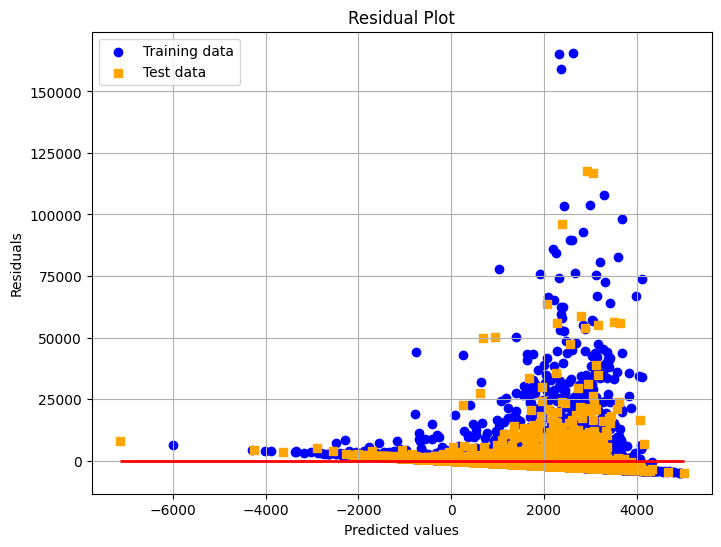

In [12]:

# Prepare data for modeling
X = cleaned_data_num.drop(columns=[
    'id', #because it is not a feature
    'num_rating', #because it is not a feature
    'num_details', #because it is not a feature
    'owned', #because it is the DV
    'rating_bayes_average', #because it is a derived value out of the DV, it is calculated using a formula for number_ratings, which in turn is strongly correlated with DV
    'wishing', #because it strongly correlated with the DV
    'wanting', #because it strongly correlated with the DV
    'trading', #because it strongly correlated with the DV
    'rating_rank', #because it strongly correlated with another IV
    'rating_users_rated', #because it strongly correlated with another IV
    'year', #because it strongly correlated with yearpublished, which is accurate.

    
    ])
y = cleaned_data_num['owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Train a linear regression model
model = Lasso(alpha=0.5)  # You can adjust the alpha parameter
model.fit(X_train, y_train)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)

# Plot residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals_train, c='blue', marker='o', label='Training data')
plt.scatter(y_pred_test, residuals_test, c='orange', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=min(y_pred_train.min(), y_pred_test.min()), xmax=max(y_pred_train.max(), y_pred_test.max()), color='red', lw=2)
plt.title('Residual Plot')
plt.grid(True)
plt.show()


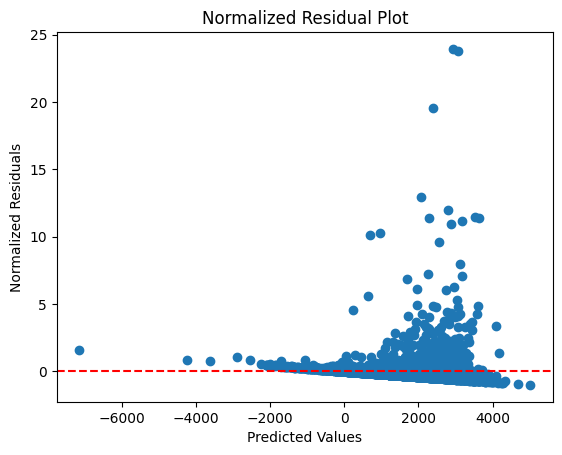

In [13]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

In [14]:

# Explode the boardgamemechanic column
exploded_mechanics = cleaned_data['boardgamemechanic'].str.strip("[]").str.replace("'", "").str.split(", ", expand=True)

# Encode the exploded mechanics into new columns
encoded_mechanics = pd.get_dummies(exploded_mechanics, prefix='Mechanic_', prefix_sep='').groupby(level=0, axis=1).max()
encoded_mechanics = encoded_mechanics.replace({True: 1, False: 0})

# Concatenate the encoded mechanics with the original dataframe
cleaned_data_encoded = pd.concat([cleaned_data_num, encoded_mechanics], axis=1)

encoded_mechanics


C:\Users\mariu\AppData\Local\Temp\ipykernel_4844\855153237.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  encoded_mechanics = pd.get_dummies(exploded_mechanics, prefix='Mechanic_', prefix_sep='').groupby(level=0, axis=1).max()
C:\Users\mariu\AppData\Local\Temp\ipykernel_4844\855153237.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_mechanics = encoded_mechanics.replace({True: 1, False: 0})


,"Mechanic_""Prisoners Dilemma""",Mechanic_Acting,Mechanic_Action Drafting,Mechanic_Action Points,Mechanic_Action Queue,Mechanic_Action Retrieval,Mechanic_Action Timer,Mechanic_Action/Event,Mechanic_Advantage Token,Mechanic_Alliances,...,Mechanic_Variable Phase Order,Mechanic_Variable Player Powers,Mechanic_Variable Set-up,Mechanic_Victory Points as a Resource,Mechanic_Voting,Mechanic_Worker Placement,Mechanic_Worker Placement with Dice Workers,Mechanic_You Choose,Mechanic_Zone of Control,Mechanic_and Pool Building
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
21627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data for modeling
X_full = cleaned_data_encoded.drop(columns=[
    'id',  # Not a feature
    'num_rating',  # Not a feature
    'num_details',  # Not a feature
    'owned',  # Dependent variable
    'rating_bayes_average',  # Derived value strongly correlated with DV
    'wishing',  # Strongly correlated with DV
    'wanting',  # Strongly correlated with DV
    'trading',  # Strongly correlated with DV
    'rating_rank',  # Strongly correlated with another independent variable
    'rating_users_rated',  # Strongly correlated with another independent variable
    'year',  # Strongly correlated with yearpublished
])

X_reduced = cleaned_data_encoded.drop(columns=[
    'id',  # Not a feature
    'num_rating',  # Not a feature
    'num_details',  # Not a feature
    'owned',  # Dependent variable
    'rating_bayes_average',  # Derived value strongly correlated with DV
    'wishing',  # Strongly correlated with DV
    'wanting',  # Strongly correlated with DV
    'trading',  # Strongly correlated with DV
    'rating_rank',  # Strongly correlated with another independent variable
    'rating_users_rated',  # Strongly correlated with another independent variable
    'year',  # Strongly correlated with yearpublished
    'yearpublished',  # Want to see the effect of controlling for it
    'rating_average',  # Want to see the effect of controlling for it
])

y = cleaned_data_encoded['owned']

# Split the data
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Add constant to the train and test sets for statsmodels
X_train_full_scaled = sm.add_constant(X_train_full_scaled)
X_test_full_scaled = sm.add_constant(X_test_full_scaled)
X_train_reduced_scaled = sm.add_constant(X_train_reduced_scaled)
X_test_reduced_scaled = sm.add_constant(X_test_reduced_scaled)

# Train Ridge regression for the full model
model_full_stats = sm.OLS(y_train, X_train_full_scaled).fit_regularized(alpha=0.5, L1_wt=0)

# Train Ridge regression for the reduced model
model_reduced_stats = sm.OLS(y_train, X_train_reduced_scaled).fit_regularized(alpha=0.5, L1_wt=0)


# Print summary for the full model
print("Full Model Summary:")
print("Intercept:", model_full_stats.params[0])
print("Coefficients:", model_full_stats.params[1:])
print("R-squared:", model_full_stats.rsquared)
print("Adjusted R-squared:", model_full_stats.rsquared_adj)
# Print other relevant information as needed

# Print summary for the reduced model
print("\nReduced Model Summary:")
print("Intercept:", model_reduced_stats.params[0])
print("Coefficients:", model_reduced_stats.params[1:])
print("R-squared:", model_reduced_stats.rsquared)
print("Adjusted R-squared:", model_reduced_stats.rsquared_adj)
# Print other relevant information as needed


Full Model Summary:
Intercept: 1010.7486515641864
Coefficients: [309.99677993  -2.04200989  47.01793874  18.67460835  -8.83484963
   9.50178716  -8.83484963  55.69768973  91.08867495 -24.1383416
 137.19724076  23.42962674  -7.05515095 127.92468221 -10.15586983
 -56.87108418 117.32326443 -30.18604656  36.23888809  14.31860834
  -6.90364681 -30.09222752  -5.03854492  91.32997278 228.26085814
  54.99827317  17.95335889  46.460667    28.33875386 153.80211899
  76.46916119  26.13053507  15.83907392  73.34753295 101.8007059
  58.39659344  -7.90810299 132.81074543 115.6162184  125.08290184
 -66.36970904 -39.85496746  29.00939749 -65.75483973  -5.87538044
 254.96637587  85.12006672  63.08307284 163.65091139 103.756806
  -1.49255893  24.81034043  -9.93675241  26.13053507 124.80817697
 -37.19829043 318.37437659  34.15306552 142.39733541   2.25397901
 -25.59545736 269.95113171  53.18178871  48.53839228 300.41448699
 -57.98261586  86.96107481  24.46206193 153.47588193 128.28724538
 157.36562668  3

AttributeError: 'RegularizedResults' object has no attribute 'rsquared'

## Overfitting, with Ridge, alpha 0.5. 

In [16]:
from sklearn.linear_model import Ridge

# Prepare data for modeling
X_full = cleaned_data_encoded.drop(columns=[
    'id',  # Not a feature
    'num_rating',  # Not a feature
    'num_details',  # Not a feature
    'owned',  # Dependent variable
    'rating_bayes_average',  # Derived value strongly correlated with DV
    'wishing',  # Strongly correlated with DV
    'wanting',  # Strongly correlated with DV
    'trading',  # Strongly correlated with DV
    'rating_rank',  # Strongly correlated with another independent variable
    'rating_users_rated',  # Strongly correlated with another independent variable
    'year',  # Strongly correlated with yearpublished
])

X_reduced = cleaned_data_encoded.drop(columns=[
    'id',  # Not a feature
    'num_rating',  # Not a feature
    'num_details',  # Not a feature
    'owned',  # Dependent variable
    'rating_bayes_average',  # Derived value strongly correlated with DV
    'wishing',  # Strongly correlated with DV
    'wanting',  # Strongly correlated with DV
    'trading',  # Strongly correlated with DV
    'rating_rank',  # Strongly correlated with another independent variable
    'rating_users_rated',  # Strongly correlated with another independent variable
    'year',  # Strongly correlated with yearpublished
    'yearpublished',  # Want to see the effect of controlling for it
    'rating_average',  # Want to see the effect of controlling for it
])

y = cleaned_data_encoded['owned']

# Split the data
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Train Ridge regression for the full model
alpha_full = 0.1  # You can adjust the alpha parameter
model_full = Ridge(alpha=alpha_full)
model_full.fit(X_train_full_scaled, y_train)

# Train Ridge regression for the reduced model
alpha_reduced = 0.1  # You can adjust the alpha parameter
model_reduced = Ridge(alpha=alpha_reduced)
model_reduced.fit(X_train_reduced_scaled, y_train)





    



Ridge(alpha=0.1)

In [17]:


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import f as f_statistic

# Generate predictions
y_pred_full = model_full.predict(X_test_full_scaled)
y_pred_reduced = model_reduced.predict(X_test_reduced_scaled)

# Calculate R-squared
r2_full = r2_score(y_test, y_pred_full)
r2_reduced = r2_score(y_test, y_pred_reduced)

# Calculate F-statistic and p-value for the full model
n_full = len(y_test)
p_full = X_test_full_scaled.shape[1]  # Number of predictors
f_stat_full = ((r2_full / (1 - r2_full)) * (n_full - p_full - 1)) / p_full
p_value_full = 1 - f_statistic.cdf(f_stat_full, p_full, n_full - p_full - 1)

# Calculate F-statistic and p-value for the reduced model
n_reduced = len(y_test)
p_reduced = X_test_reduced_scaled.shape[1]  # Number of predictors
f_stat_reduced = ((r2_reduced / (1 - r2_reduced)) * (n_reduced - p_reduced - 1)) / p_reduced
p_value_reduced = 1 - f_statistic.cdf(f_stat_reduced, p_reduced, n_reduced - p_reduced - 1)

# Print the report
print("Regression Report:")
print("===================")
print("Full Model:")
print(f"R-squared: {r2_full}")
print(f"F-statistic: {f_stat_full}")
print(f"p-value: {p_value_full}")
print("\nCoefficients:")
for feature, coef in zip(X_full.columns, model_full.coef_):
    print(f"{feature}: {coef}")
    
print("\nReduced Model:")
print(f"R-squared: {r2_reduced}")
print(f"F-statistic: {f_stat_reduced}")
print(f"p-value: {p_value_reduced}")
print("\nCoefficients:")
for feature, coef in zip(X_reduced.columns, model_reduced.coef_):
    print(f"{feature}: {coef}")



Regression Report:
Full Model:
R-squared: 0.10236439236925099
F-statistic: 2.4420634134104433
p-value: 1.1102230246251565e-16

Coefficients:
rating_average: 402.7542605015343
yearpublished: -12.688212890924413
minplayers: 116.72628722904413
maxplayers: 36.55096242828487
playingtime: -46.132177253648074
minplaytime: 79.59776031500454
maxplaytime: -46.1321772526586
minage: 28.20666004212264
Mechanic_"Prisoners Dilemma": 126.94566304798603
Mechanic_Acting: -44.04022092364951
Mechanic_Action Drafting: 145.6045088728528
Mechanic_Action Points: 18.35597637638469
Mechanic_Action Queue: -25.745256935186635
Mechanic_Action Retrieval: 148.82306308077693
Mechanic_Action Timer: -15.791455058959425
Mechanic_Action/Event: -91.94406446052818
Mechanic_Advantage Token: 144.7589257385252
Mechanic_Alliances: -70.65604524350587
Mechanic_Area Majority / Influence: 29.996940164101233
Mechanic_Area Movement: 20.094665399415174
Mechanic_Area-Impulse: -8.343160008235262
Mechanic_Auction/Bidding: -72.7083720046

In [18]:

# Get coefficients for the full model
coefficients_full = pd.DataFrame({'Feature': X_train_full.columns, 'Coefficient': model_full.coef_})
coefficients_full['AbsoluteCoefficient'] = abs(coefficients_full['Coefficient'])
coefficients_full_sorted = coefficients_full.sort_values(by='AbsoluteCoefficient', ascending=False).drop(columns=['AbsoluteCoefficient'])

# Get coefficients for the reduced model
coefficients_reduced = pd.DataFrame({'Feature': X_train_reduced.columns, 'Coefficient': model_reduced.coef_})
coefficients_reduced['AbsoluteCoefficient'] = abs(coefficients_reduced['Coefficient'])
coefficients_reduced_sorted = coefficients_reduced.sort_values(by='AbsoluteCoefficient', ascending=False).drop(columns=['AbsoluteCoefficient'])
# Separate coefficients for Mechanic_ features and other features for the full model
mechanic_features_full = coefficients_full_sorted[coefficients_full_sorted['Feature'].str.startswith('Mechanic_')]
other_features_full = coefficients_full_sorted[~coefficients_full_sorted['Feature'].str.startswith('Mechanic_')]

# Separate coefficients for Mechanic_ features and other features for the reduced model
mechanic_features_reduced = coefficients_reduced_sorted[coefficients_reduced_sorted['Feature'].str.startswith('Mechanic_')]
other_features_reduced = coefficients_reduced_sorted[~coefficients_reduced_sorted['Feature'].str.startswith('Mechanic_')]

# Print table for Mechanic_ features for the full model
print("\nFull Model Coefficients for Mechanic_ Features (sorted by absolute value):")
print(mechanic_features_full)

# Print table for other features for the full model
print("\nFull Model Coefficients for Other Features (sorted by absolute value):")
print(other_features_full)

# Print table for Mechanic_ features for the reduced model
print("\nReduced Model Coefficients for Mechanic_ Features (sorted by absolute value):")
print(mechanic_features_reduced)

# Print table for other features for the reduced model
print("\nReduced Model Coefficients for Other Features (sorted by absolute value):")
print(other_features_reduced)


Full Model Coefficients for Mechanic_ Features (sorted by absolute value):
                            Feature  Coefficient
56        Mechanic_Delayed Purchase   491.941749
96            Mechanic_Map Addition   476.227539
133      Mechanic_Random Production   400.599186
75            Mechanic_Hidden Roles   390.878055
64        Mechanic_End Game Bonuses   376.425751
..                              ...          ...
79                   Mechanic_I Cut    -3.372648
118       Mechanic_Paper-and-Pencil     3.359213
120       Mechanic_Pattern Building    -2.808417
44   Mechanic_Commodity Speculation     1.481504
50      Mechanic_Crayon Rail System    -0.027126

[185 rows x 2 columns]

Full Model Coefficients for Other Features (sorted by absolute value):
          Feature  Coefficient
0  rating_average   402.754261
2      minplayers   116.726287
5     minplaytime    79.597760
4     playingtime   -46.132177
6     maxplaytime   -46.132177
3      maxplayers    36.550962
7          minage    28

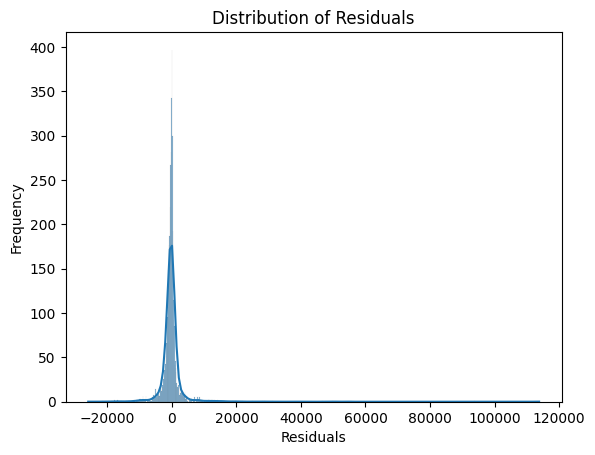

In [22]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_test - y_pred_reduced

# Plot the distribution of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_train - y_pred_full

# Plot the distribution of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()